#### HOMEWORK 14

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)


2024-07-21 20:21:20.261457: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 20:21:20.268896: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 20:21:20.324415: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 20:21:20.420965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 20:21:20.503112: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

#### Step 0: Dataset Inspection

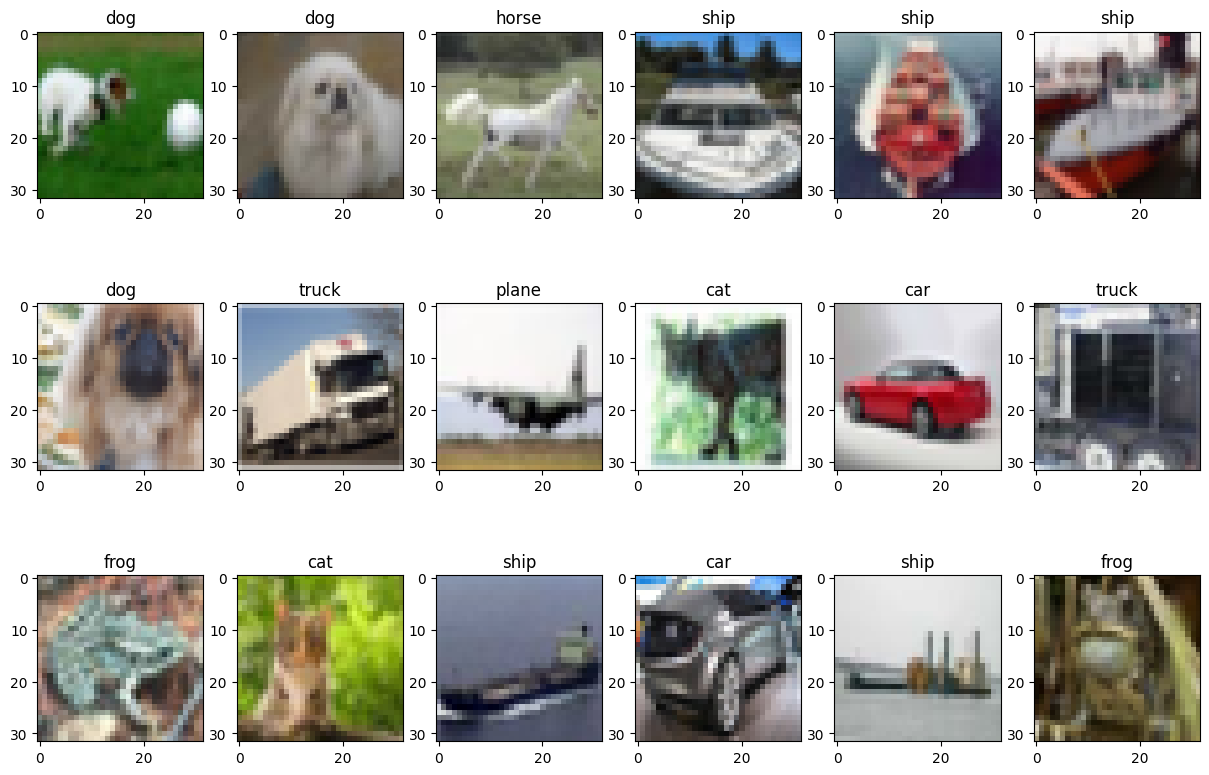

In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Mapping from class ID to class name
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer',
           5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# Dataset params
num_classes = len(classes)
size = x_train.shape[1]

# Visualize random samples (as a plot with 3x6 samples)
for ii in range(18):    
    plt.subplot(3,6,ii+1)
    # Pick a random sample
    idx = np.random.randint(0, len(x_train))
    # Show the image and the label
    plt.imshow(x_train[idx, ...])
    plt.title(classes[int(y_train[idx])])

In [3]:
# Compute the class histogram
hist, bins = np.histogram(y_train, bins=range(num_classes + 1))

#### Step 1: Data Preparation

In [4]:
# Normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    50000 samples
Test set:     10000 samples
Sample dims:  (50000, 32, 32, 3)


#### Step 2: Building the Classifier

In [5]:
# Build the classifier
model = tf.keras.Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Show the model
model.summary()

/usr/local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Step 3: Training

In [6]:
epochs = 25
batch_size = 128

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test))

Epoch 1/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.3364 - loss: 1.8179 - val_accuracy: 0.5384 - val_loss: 1.2780
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.5688 - loss: 1.2116 - val_accuracy: 0.6357 - val_loss: 1.0350
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.6448 - loss: 1.0084 - val_accuracy: 0.6659 - val_loss: 0.9677
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.6916 - loss: 0.8847 - val_accuracy: 0.6795 - val_loss: 0.9249
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7232 - loss: 0.8013 - val_accuracy: 0.6908 - val_loss: 0.9032
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.7485 - loss: 0.7280 - val_accuracy: 0.6993 - val_loss: 0.8910
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.7688 - loss: 0.6661 - val_accuracy: 0.7161 - val_loss: 0.8445
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.7864 - loss: 0.6159 - 

Train Acc      0.9444199800491333
Validation Acc 0.6953999996185303


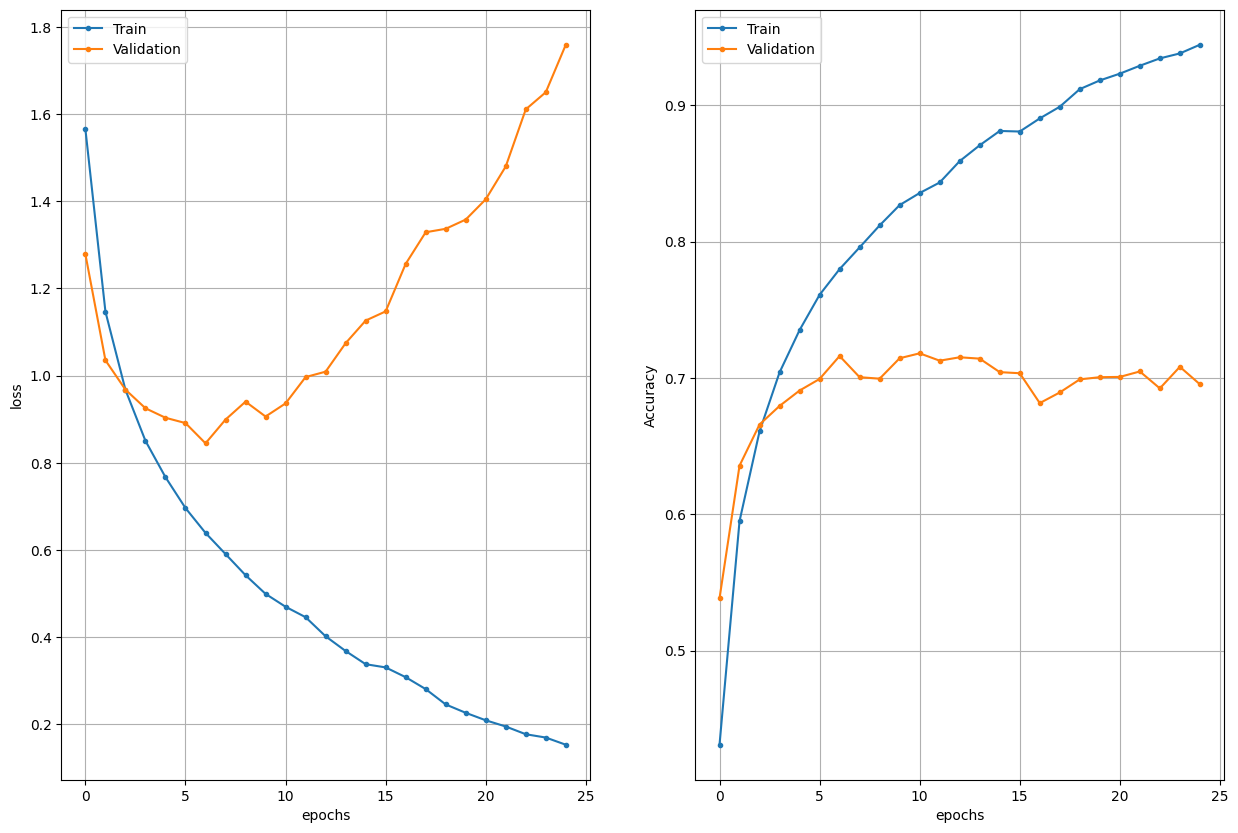

In [7]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])  

#### Step 4: Evaluation

In [8]:
# Compute the labels and the predictions as sparse values
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [9]:
for class_id, class_name in classes.items():
    indices = np.where(y_true == class_id)
    acc = np.mean(y_true[indices] == y_pred[indices])
    print(class_name, acc)

plane 0.777
car 0.821
bird 0.645
cat 0.572
deer 0.526
dog 0.665
frog 0.748
horse 0.729
ship 0.825
truck 0.646


In [10]:
# Evaluate the model
ev = model.evaluate(x_test, y_test)

print('Test loss  ', ev[0])
print('Test metric', ev[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6998 - loss: 1.7396
Test loss   1.7588595151901245
Test metric 0.6953999996185303


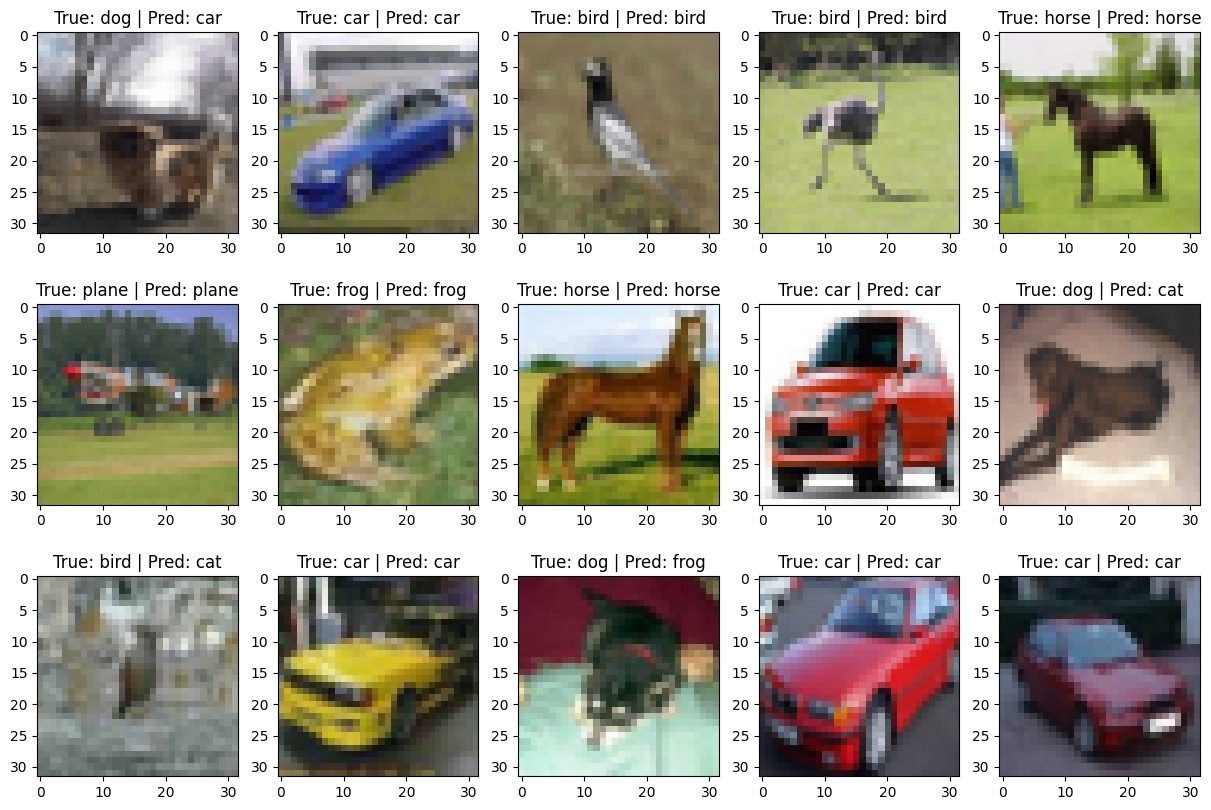

In [11]:
# Show random samples
for ii in range(15):
    # Pick a random sample
    idx = np.random.randint(0, len(x_test))
    # Show the results
    plt.subplot(3, 5, ii + 1), plt.imshow(x_test[idx, ...])
    plt.title('True: ' + str(classes[y_true[idx]]) + ' | Pred: ' + str(classes[y_pred[idx]]))

### Questions

#### What is the overall accuracy of the classifier?
- answer

#### What modifications would you do in order to improve the classification accuracy?
- answer

#### Make one modification (that you think can help) and train the classifier again. Does the accuracy improve?


In [12]:
from tensorflow.keras.layers import Dropout

# Build the classifier
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    Dropout(0.5),  # Add Dropout layer here
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# compile and train the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test))

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.3308 - loss: 1.8171 - val_accuracy: 0.5260 - val_loss: 1.3047
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.5443 - loss: 1.2724 - val_accuracy: 0.6058 - val_loss: 1.1129
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.6161 - loss: 1.0858 - val_accuracy: 0.6622 - val_loss: 0.9634
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.6547 - loss: 0.9740 - val_accuracy: 0.6786 - val_loss: 0.9200
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.6872 - loss: 0.8918 - val_accuracy: 0.7089 - val_loss: 0.8379
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.7085 - loss: 0.8307 - val_accuracy: 0.7021 - val_loss: 0.8550
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.7243 - loss: 0.7853 - val_accuracy: 0.7188 - val_loss: 0.7993
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.7369 - loss: 0.7531 - 

In [15]:
# evaluate model
ev = model.evaluate(x_test, y_test)
print('Test loss: ', ev[0])
print('Test metric: ', ev[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7822 - loss: 0.7118
Test loss:  0.7157726287841797
Test metric:  0.7777000069618225


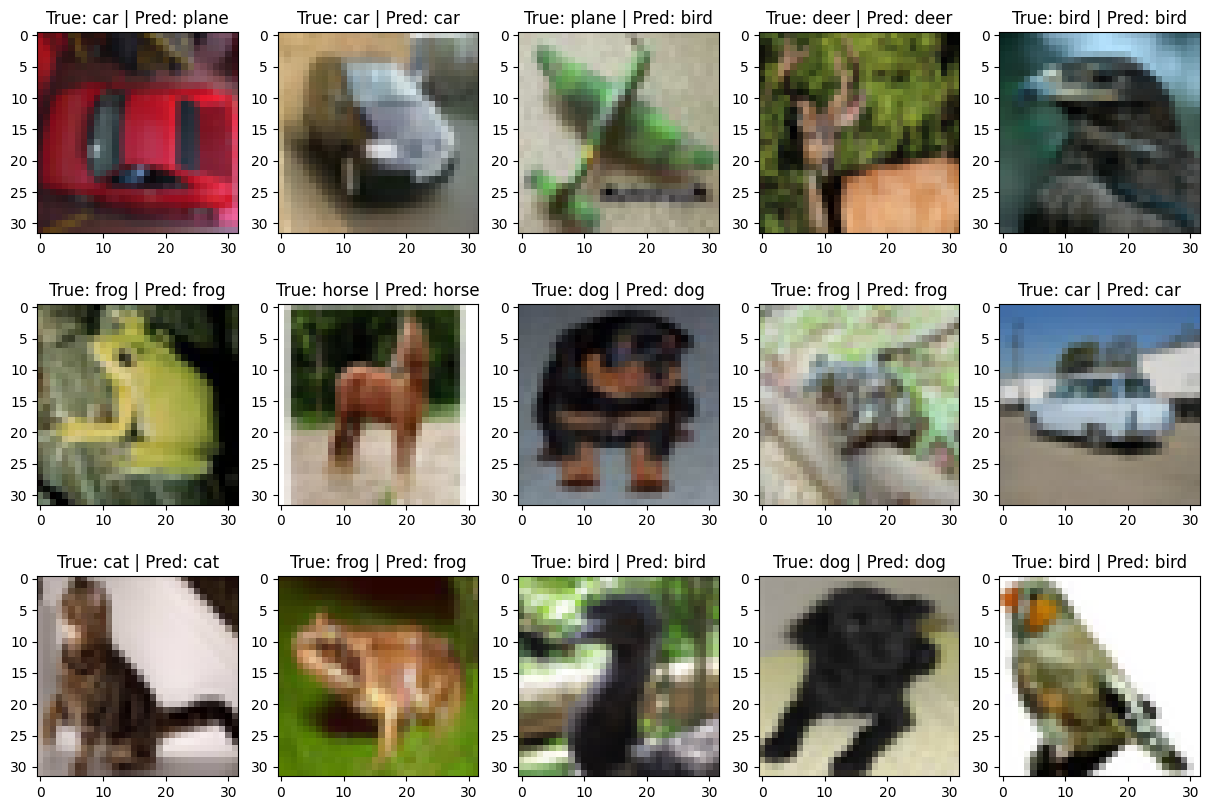

In [16]:
# Show random samples
for ii in range(15):
    # Pick a random sample
    idx = np.random.randint(0, len(x_test))
    # Show the results
    plt.subplot(3, 5, ii + 1), plt.imshow(x_test[idx, ...])
    plt.title('True: ' + str(classes[y_true[idx]]) + ' | Pred: ' + str(classes[y_pred[idx]]))